# Notebook principal

Sistema de predicción espacio temporal de altos riesgos delictivos

# Limpieza datos ECU911

limpieza_de_datos_ecu_911

In [1]:
import os
import glob
import pandas as pd

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
RUTA_PADRE = "../data"
RUTA_ECU911_RAW = os.path.join(RUTA_PADRE, "raw", "ecu911", "dataset")
PATRON_CSV = os.path.join(RUTA_ECU911_RAW, "*.csv")

SALIDA_LIMPIA = os.path.join(RUTA_PADRE, "interim", "ecu911", "ecu911_limpio.csv")
os.makedirs(os.path.dirname(SALIDA_LIMPIA), exist_ok=True)

archivos_csv = glob.glob(PATRON_CSV)
print(f"Archivos CSV encontrados: {len(archivos_csv)}")
print("Ejemplo:", archivos_csv[:3])

Archivos CSV encontrados: 10
Ejemplo: ['../data\\raw\\ecu911\\dataset\\incidentes_abril_2025.csv', '../data\\raw\\ecu911\\dataset\\incidentes_agosto_2025.csv', '../data\\raw\\ecu911\\dataset\\incidentes_enero_2025.csv']


In [2]:
def normalizar_columnas (df: pd.DataFrame):
  df = df.copy()
  df.columns = (
    df.columns.astype(str)
    .str.replace("ï»¿", "", regex=False)
    .str.strip()
    .str.lower()
  )
  return df

def limpiar_texto_basico(serie: pd.Series) -> pd.Series:
  s = serie.astype(str).str.strip()
  s = s.replace({"": pd.NA, "nan": pd.NA, "none": pd.NA, "null": pd.NA})
  return s

def estandarizar_cod_parroquia(serie: pd.Series) -> pd.Series:
  s = limpiar_texto_basico(serie)
  s = s.str.replace(".0", "", regex=False)
  s = s.str.zfill(6)
  return s

def parsear_fecha(serie: pd.Series) -> pd.Series:
    # Convierte a datetime de forma robusta
    return pd.to_datetime(serie, errors="coerce", dayfirst=True)


def limpiar_lat_lon(df: pd.DataFrame, col_lat="lat", col_lon="lon") -> pd.DataFrame:
    """
    Limpia lat/lon si existen: convierte coma->punto, numérico, elimina nulos,
    elimina ceros y rangos inválidos.
    """
    df = df.copy()

    if col_lat not in df.columns or col_lon not in df.columns:
        print(f"Aviso: no existen columnas {col_lat}/{col_lon}. Se omite limpieza lat/lon.")
        return df

    for col in [col_lat, col_lon]:
        df[col] = (
            df[col]
            .astype(str)
            .str.strip()
            .str.replace(",", ".", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

    antes = len(df)
    df = df.dropna(subset=[col_lat, col_lon])

    # Quitar ceros (como en tu ejemplo)
    df = df[(df[col_lat] != 0) & (df[col_lon] != 0)]

    # Rangos válidos geográficos
    df = df[(df[col_lat].between(-90, 90)) & (df[col_lon].between(-180, 180))]

    print(f"Limpieza lat/lon: eliminados {antes - len(df)} registros inválidos.")
    return df


def leer_csv_ecu911(path_csv: str) -> pd.DataFrame:
    """
    Lee CSV ECU911 con separador ';', normaliza columnas y aplica filtro
    (si aplica) sin crear features.
    """
    df = pd.read_csv(
        path_csv,
        sep=";",
        encoding="UTF-8",
        on_bad_lines="skip",
        low_memory=False
    )
    df = normalizar_columnas(df)
    return df



In [3]:
dfs = []
errores = []

print("Cargando archivos ECU911... esto puede tardar unos segundos...")

for archivo in archivos_csv:
    try:
        df_tmp = leer_csv_ecu911(archivo)
        # df_tmp["__source_file"] = os.path.basename(archivo)  # trazabilidad (opcional)
        dfs.append(df_tmp)
    except Exception as e:
        errores.append((archivo, str(e)))

if errores:
    print(f"Archivos con error: {len(errores)}")
    print("Ejemplo:", errores[0])

df_911 = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

print(f"Registros totales unificados: {len(df_911)}")
print(f"Columnas: {list(df_911.columns)}")
df_911.head()

Cargando archivos ECU911... esto puede tardar unos segundos...
Registros totales unificados: 2679924
Columnas: ['fecha', 'provincia', 'canton', 'cod_parroquia', 'parroquia', 'servicio', 'subtipo']


,fecha,provincia,canton,cod_parroquia,parroquia,servicio,subtipo
0,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Violencia contra la mujer o miembros del núcle...
1,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Patrullaje policial en el sector solicitado
2,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Servicios Municipales,Libadores - GAD
3,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Patrullaje policial en el sector solicitado
4,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Robo de motos


In [4]:
# -----------------------------
# 1) FILTRO OPCIONAL (si forma parte de limpieza por alcance)
# -----------------------------
if "servicio" in df_911.columns:
    antes = len(df_911)
    df_911["servicio"] = limpiar_texto_basico(df_911["servicio"])
    df_911 = df_911[df_911["servicio"] == "Seguridad Ciudadana"]
    print(f"Filtro servicio=Seguridad Ciudadana: eliminados {antes - len(df_911)}")

# -----------------------------
# 2) LIMPIEZA DE FECHA
# -----------------------------
if "fecha" in df_911.columns:
    # Parsear fecha original
    df_911["fecha_dt"] = parsear_fecha(df_911["fecha"])
    
    antes = len(df_911)
    df_911 = df_911.dropna(subset=["fecha_dt"])
    print(f"Fechas inválidas eliminadas: {antes - len(df_911)}")
    
    # Eliminar columna original y renombrar
    df_911 = df_911.drop(columns=["fecha"])
    df_911 = df_911.rename(columns={"fecha_dt": "fecha"})
    
    # Asegurar tipo datetime
    df_911["fecha"] = pd.to_datetime(df_911["fecha"])
else:
    print("Aviso: no existe columna 'fecha'.")


# -----------------------------
# 3) LIMPIEZA DE COD_PARROQUIA (solo formato, sin cruce)
# -----------------------------
# Nota: tras normalizar columnas, normalmente quedará 'cod_parroquia' aunque viniera como 'Cod_Parroquia'
if "cod_parroquia" in df_911.columns:
    df_911["cod_parroquia"] = estandarizar_cod_parroquia(df_911["cod_parroquia"])
    antes = len(df_911)
    df_911 = df_911.dropna(subset=["cod_parroquia"])
    print(f"Códigos de parroquia vacíos eliminados: {antes - len(df_911)}")
else:
    # Esto es útil para diagnosticar cómo se llama realmente
    posibles = [c for c in df_911.columns if "parroq" in c or "parro" in c]
    print("Aviso: no existe 'cod_parroquia'. Candidatas:", posibles)



Filtro servicio=Seguridad Ciudadana: eliminados 905747
Fechas inválidas eliminadas: 0
Códigos de parroquia vacíos eliminados: 204


In [5]:
# Intenta limpiar lat/lon con nombres típicos: lat/lon
df_911 = limpiar_lat_lon(df_911, col_lat="lat", col_lon="lon")

# Si tu dataset usa "latitud"/"longitud" en vez de lat/lon, usa esto:
# df_911 = limpiar_lat_lon(df_911, col_lat="latitud", col_lon="longitud")

print(f"Registros después de limpieza lat/lon (si aplicó): {len(df_911)}")


Aviso: no existen columnas lat/lon. Se omite limpieza lat/lon.
Registros después de limpieza lat/lon (si aplicó): 1773973


In [6]:
try:
    df_911.to_csv(SALIDA_LIMPIA, index=False, encoding="utf-8")
    print("Dataset limpio guardado correctamente.")
    print("Salida:", SALIDA_LIMPIA)
    print("Registros finales:", len(df_911))
except Exception as e:
    print("Error guardando el CSV:", e)


Dataset limpio guardado correctamente.
Salida: ../data\interim\ecu911\ecu911_limpio.csv
Registros finales: 1773973


In [7]:
dfs = []
errores = []

print("Cargando archivos ECU911... esto puede tardar unos segundos...")

for archivo in archivos_csv:
    try:
        df_tmp = leer_csv_ecu911(archivo)
        # df_tmp["__source_file"] = os.path.basename(archivo)  # trazabilidad (opcional)
        dfs.append(df_tmp)
    except Exception as e:
        errores.append((archivo, str(e)))

if errores:
    print(f"Archivos con error: {len(errores)}")
    print("Ejemplo:", errores[0])

df_911 = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

print(f"Registros totales unificados: {len(df_911)}")
print(f"Columnas: {list(df_911.columns)}")
df_911.head()

Cargando archivos ECU911... esto puede tardar unos segundos...
Registros totales unificados: 2679924
Columnas: ['fecha', 'provincia', 'canton', 'cod_parroquia', 'parroquia', 'servicio', 'subtipo']


,fecha,provincia,canton,cod_parroquia,parroquia,servicio,subtipo
0,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Violencia contra la mujer o miembros del núcle...
1,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Patrullaje policial en el sector solicitado
2,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Servicios Municipales,Libadores - GAD
3,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Patrullaje policial en el sector solicitado
4,1/4/2025,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150.0,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",Seguridad Ciudadana,Robo de motos


# ECU911 preprocesamiento con coords

preprocesamiento_datos_ecu911

In [18]:
import os
import pandas as pd

RUTA_PADRE = "../data"

RUTA_LIMPIO = os.path.join(RUTA_PADRE, "interim", "ecu911", "ecu911_limpio.csv")
RUTA_CATALOGO = os.path.join(RUTA_PADRE, "raw","catalogo_parroquias", "catalogo_parroquias_ecuador.csv")

SALIDA_PREPRO = os.path.join(RUTA_PADRE, "processed", "ecu911", "ecu911_con_coords.csv")
os.makedirs(os.path.dirname(SALIDA_PREPRO), exist_ok=True)

print("Ruta limpio:", RUTA_LIMPIO)
print("Ruta catálogo:", RUTA_CATALOGO)
print("Salida:", SALIDA_PREPRO)

Ruta limpio: ../data\interim\ecu911\ecu911_limpio.csv
Ruta catálogo: ../data\raw\catalogo_parroquias\catalogo_parroquias_ecuador.csv
Salida: ../data\processed\ecu911\ecu911_con_coords.csv


In [19]:
def normalizar_columnas(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.replace("ï»¿", "", regex=False)
        .str.strip()
        .str.lower()
    )
    return df

def estandarizar_cod_parroquia(serie: pd.Series) -> pd.Series:
    s = serie.astype(str).str.strip()
    s = s.str.replace(".0", "", regex=False)
    s = s.str.zfill(6)
    s = s.replace({"nan": pd.NA, "none": pd.NA, "": pd.NA})
    return s


In [20]:
try:
    print("Cargando dataset limpio...")
    df_911 = pd.read_csv(RUTA_LIMPIO, low_memory=False)
    df_911 = normalizar_columnas(df_911)
    print("Registros:", len(df_911))
    print("Columnas:", list(df_911.columns))
except Exception as e:
    raise RuntimeError(f"Error cargando dataset limpio: {e}")


Cargando dataset limpio...
Registros: 1773973
Columnas: ['provincia', 'canton', 'cod_parroquia', 'parroquia', 'servicio', 'subtipo', 'fecha']


In [21]:
try:
    print("Cargando catálogo de parroquias...")
    catalogo = pd.read_csv(RUTA_CATALOGO, dtype={"cod_parroquia": str}, low_memory=False)
    catalogo = normalizar_columnas(catalogo)
    print("Filas catálogo:", len(catalogo))
    print("Columnas catálogo:", list(catalogo.columns))
except Exception as e:
    raise RuntimeError(f"Error cargando catálogo: {e}")


Cargando catálogo de parroquias...
Filas catálogo: 1257
Columnas catálogo: ['cod_parroquia', 'provincia', 'canton', 'parroquia', 'direccion_busqueda', 'lat', 'lon']


In [22]:
# Validar que exista cod_parroquia en ambos
if "cod_parroquia" not in df_911.columns:
    raise ValueError("El dataset limpio no tiene 'cod_parroquia'. Revisa nombres de columnas.")

if "cod_parroquia" not in catalogo.columns:
    raise ValueError("El catálogo no tiene 'cod_parroquia'. Revisa nombres de columnas.")

# Estandarizar
df_911["cod_parroquia"] = estandarizar_cod_parroquia(df_911["cod_parroquia"])
catalogo["cod_parroquia"] = estandarizar_cod_parroquia(catalogo["cod_parroquia"])

# Validar lat/lon
# Si en tu catálogo se llaman distinto, cámbialos aquí.
lat_col = "lat"
lon_col = "lon"

if lat_col not in catalogo.columns or lon_col not in catalogo.columns:
    raise ValueError(f"El catálogo no tiene columnas '{lat_col}'/'{lon_col}'. Columnas disponibles: {list(catalogo.columns)}")

# Mantener solo lo necesario del catálogo para evitar columnas repetidas
catalogo_coords = catalogo[["cod_parroquia", lat_col, lon_col]].drop_duplicates(subset=["cod_parroquia"])
print("Catálogo coords (únicos por cod_parroquia):", len(catalogo_coords))


Catálogo coords (únicos por cod_parroquia): 1048


In [23]:
antes = len(df_911)

df_merge = df_911.merge(
    catalogo_coords,
    on="cod_parroquia",
    how="left"
)

print("Registros tras merge:", len(df_merge), "(debería ser igual a antes:", antes, ")")


Registros tras merge: 1773973 (debería ser igual a antes: 1773973 )


In [24]:
total = len(df_merge)
sin_latlon = df_merge[lat_col].isna().sum()

print("Total registros:", total)
print("Sin coordenadas:", sin_latlon)
print("Con coordenadas:", total - sin_latlon)
print("Match rate:", f"{(total - sin_latlon)/total*100:.2f}%")

# Top parroquias sin match (para depuración)
top_sin_match = (
    df_merge[df_merge[lat_col].isna()]
    .groupby("cod_parroquia")
    .size()
    .sort_values(ascending=False)
    .head(15)
)

print("\nTop cod_parroquia sin match (conteo de llamadas):")
print(top_sin_match)


Total registros: 1773973
Sin coordenadas: 638
Con coordenadas: 1773335
Match rate: 99.96%

Top cod_parroquia sin match (conteo de llamadas):
cod_parroquia
900451    245
900151    195
140157    140
220254     31
011551     27
dtype: int64


In [25]:
df_merge = df_merge.sort_values(by="fecha", ascending=True)
df_merge = df_merge.reset_index(drop=True)


In [26]:
# Opcional: quedarte solo con filas con coordenadas
df_final = df_merge.dropna(subset=[lat_col, lon_col]).copy()

df_final.to_csv(SALIDA_PREPRO, index=False, encoding="utf-8")
print("Guardado:", SALIDA_PREPRO)
print("Registros finales con coords:", len(df_final))


Guardado: ../data\processed\ecu911\ecu911_con_coords.csv
Registros finales con coords: 1773335


# ECU911 subtipos frecuentes

exploracion_ecu_911

In [27]:
import os
import pandas as pd

RUTA_PADRE = "../data"

RUTA_LIMPIO = os.path.join(RUTA_PADRE, "processed", "ecu911", "ecu911_con_coords.csv")


SALIDA_CONSULTA = os.path.join(RUTA_PADRE, "processed", "ecu911", "ecu911_subtipos_frecuentes.csv")
os.makedirs(os.path.dirname(SALIDA_CONSULTA), exist_ok=True)

print("Ruta limpio:", RUTA_LIMPIO)

print("Salida:", SALIDA_CONSULTA)

Ruta limpio: ../data\processed\ecu911\ecu911_con_coords.csv
Salida: ../data\processed\ecu911\ecu911_subtipos_frecuentes.csv


In [28]:
df_ecu911 = pd.read_csv(RUTA_LIMPIO)
subtipos_frecuentes = df_ecu911['subtipo'].value_counts().reset_index()
subtipos_frecuentes.columns = ['subtipo', 'frecuencia']

subtipos_frecuentes.to_csv(SALIDA_CONSULTA, index=False)

# Preprocesamiento aprehendidos/detenidos

preprocesamiento_detenidosaprehendidos

In [29]:
import pandas as pd
import numpy as np

#carga de datos
nombre_archivo = '../data/raw/aprehendidos_detenidos/dataset/mdi_detenidosaprehendidos_pm_2025_enero_octubre.xlsx'

In [30]:
try:
    print("Cargando archivo Excel... esto puede tardar unos segundos...")
    df_apre = pd.read_excel(
        nombre_archivo,
        sheet_name=1,
        dtype={'codigo_parroquia': str},  # proteger columna
        engine='openpyxl'
    )
    print(f"¡Cargado! Registros totales: {len(df_apre)}")

except Exception as e:
    print("Error cargando el Excel:", e)

Cargando archivo Excel... esto puede tardar unos segundos...
¡Cargado! Registros totales: 61149


In [31]:
# normalización de datos de latitud y longitud
for col in ["latitud", "longitud"]:
    df_apre[col] = (
        df_apre[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
    )
    df_apre[col] = pd.to_numeric(df_apre[col], errors="coerce")

# quitar filas sin coordenadas válidas
df_apre = df_apre.dropna(subset=["latitud", "longitud"])
df_apre = df_apre[(df_apre["latitud"] != 0) & (df_apre["longitud"] != 0)]

In [32]:
#nromalizar fecha y hora de detención/aprehensión
try:
    df_apre["fecha"] = pd.to_datetime(df_apre["fecha_detencion_aprehension"], errors="coerce")

    # hora como string limpio
    df_apre["hora_limpia"] = (
        df_apre["hora_detencion_aprehension"]
        .astype(str)
        .str.replace(" ", "")
        .str.strip()
    )

    # Combinar fecha + hora
    df_apre["fecha_completa"] = pd.to_datetime(
        df_apre["fecha"].astype(str) + " " + df_apre["hora_limpia"],
        errors="coerce"
    )

except Exception as e:
    print("Advertencia procesando fecha/hora:", e)

In [33]:
#estandarizar el codd parroquia
if "codigo_parroquia" in df_apre.columns:
    df_apre["codigo_parroquia"] = (
        df_apre["codigo_parroquia"]
        .astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.zfill(6)
    )


#columnas de interes
cols_interes = [
    "fecha_completa", "fecha", "latitud", "longitud",
    "codigo_parroquia", "nombre_parroquia",
    "presunta_infraccion", "tipo", "arma", "movilizacion"
]

df_apre_clean = df_apre[cols_interes].copy()

# features temporales
df_apre_clean["franja_horaria"] = df_apre_clean["fecha_completa"].dt.hour
df_apre_clean["dia"] = df_apre_clean["fecha_completa"].dt.day
df_apre_clean["mes"] = df_apre_clean["fecha_completa"].dt.month
df_apre_clean["dia_semana"] = df_apre_clean["fecha_completa"].dt.dayofweek  # 0=Lunes

#grid espacial
df_apre_clean["lat_grid"] = df_apre_clean["latitud"].round(3)
df_apre_clean["lon_grid"] = df_apre_clean["longitud"].round(3)


#conteo de delios por dia y zona
grouped = (
    df_apre_clean
    .groupby(["lat_grid", "lon_grid", "fecha"])
    .size()
    .reset_index(name="conteo_delitos")
)

df_apre_clean = df_apre_clean.merge(
    grouped,
    on=["lat_grid", "lon_grid", "fecha"],
    how="left"
)


#guardar dataset limpio
print("\n=== Dataset final limpio ===")
print(df_apre_clean.head())
print(f"Total registros finales: {len(df_apre_clean)}")


=== Dataset final limpio ===
       fecha_completa      fecha   latitud   longitud codigo_parroquia  \
0 2025-02-03 08:00:00 2025-02-03 -3.715507 -79.618370           071150   
1 2025-05-16 13:40:00 2025-05-16 -1.046660 -77.742967           150155   
2 2025-05-20 13:30:00 2025-05-20 -2.260877 -79.878447           090150   
3 2025-04-11 17:00:00 2025-04-11 -3.270166 -79.953237           070150   
4 2025-09-18 15:30:00 2025-09-18 -0.951131 -79.358865           121150   

     nombre_parroquia                                presunta_infraccion  \
0           PORTOVELO                                            BOLETAS   
1   PUERTO MISAHUALLI                DELITOS CONTRA LOS RECURSOS MINEROS   
2  GUAYAQUIL-FLORESTA                                            BOLETAS   
3             MACHALA  DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...   
4            VALENCIA  DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...   

          tipo     arma  movilizacion  franja_horaria  dia  mes  dia

In [34]:


print("--- Primeras Filas---")
print(df_apre_clean.head())
print("\n--- Tipos de datos ---")
print(df_apre_clean.dtypes)

--- Primeras Filas---
       fecha_completa      fecha   latitud   longitud codigo_parroquia  \
0 2025-02-03 08:00:00 2025-02-03 -3.715507 -79.618370           071150   
1 2025-05-16 13:40:00 2025-05-16 -1.046660 -77.742967           150155   
2 2025-05-20 13:30:00 2025-05-20 -2.260877 -79.878447           090150   
3 2025-04-11 17:00:00 2025-04-11 -3.270166 -79.953237           070150   
4 2025-09-18 15:30:00 2025-09-18 -0.951131 -79.358865           121150   

     nombre_parroquia                                presunta_infraccion  \
0           PORTOVELO                                            BOLETAS   
1   PUERTO MISAHUALLI                DELITOS CONTRA LOS RECURSOS MINEROS   
2  GUAYAQUIL-FLORESTA                                            BOLETAS   
3             MACHALA  DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...   
4            VALENCIA  DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...   

          tipo     arma  movilizacion  franja_horaria  dia  mes  dia_semana 

In [35]:
# 2. Validación Geográfica Rápida
print("--- Rango de Coordenadas ---")
print(f"Latitud: {df_apre_clean['latitud'].min()} a {df_apre_clean['latitud'].max()}")
print(f"Longitud: {df_apre_clean['longitud'].min()} a {df_apre_clean['longitud'].max()}")


--- Rango de Coordenadas ---
Latitud: -4.977575151 a 2.087691416
Longitud: -90.983276367 a 79.913899269


In [36]:

# 3. Delitos más comunes
print("\n--- Top 10 Infracciones ---")
print(df_apre_clean['presunta_infraccion'].value_counts().head(10))


--- Top 10 Infracciones ---
presunta_infraccion
DELITOS CONTRA EL DERECHO A LA PROPIEDAD                                                         10727
BOLETAS                                                                                           9181
DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN     9139
CONTRAVENCIONES DE TRÁNSITO                                                                       6080
DELITOS CONTRA LA SEGURIDAD PÚBLICA                                                               5177
CONTRAVENCIÓN DE VIOLENCIA CONTRA LA MUJER O MIEMBROS DEL NÚCLEO FAMILIAR                         3356
DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBROS DEL NÚCLEO FAMILIAR                               2884
DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRACIÓN PÚBLICA                                         2245
CONTRAVENCIONES                                                                                   1546
DELITOS CULPOSOS DE TRÁN

In [37]:
# ============================================================
# CLASIFICACIÓN DE DELITOS GRAVES
# ============================================================

delitos_interes = [
    'DELITOS CONTRA EL DERECHO A LA PROPIEDAD',
    'DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN',
    'DELITOS CONTRA LA SEGURIDAD PÚBLICA',
    'DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRACIÓN PÚBLICA',
    'DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBROS DEL NÚCLEO FAMILIAR'
]

# 1. Etiqueta de delito grave (0/1)
df_apre_clean["es_delito_grave"] = df_apre_clean["presunta_infraccion"].isin(delitos_interes).astype(int)

# 2. Conteo solo de delitos graves (target alternativo)
df_graves = (
    df_apre_clean[df_apre_clean["es_delito_grave"] == 1]
    .groupby(["lat_grid", "lon_grid", "fecha"])
    .size()
    .reset_index(name="conteo_delitos_graves")
)

# Asegurar que no exista antes de unir
if "conteo_delitos_graves" in df_apre_clean.columns:
    df_apre_clean.drop(columns=["conteo_delitos_graves"], inplace=True)

# Merge limpio
df_apre_clean = df_apre_clean.merge(
    df_graves,
    on=["lat_grid", "lon_grid", "fecha"],
    how="left"
)

# Rellenar NaN con 0 (ningún delito grave en esa celda y día)
df_apre_clean["conteo_delitos_graves"] = df_apre_clean["conteo_delitos_graves"].fillna(0)

In [38]:
# ============================================================
# LIMPIEZA DE POSIBLES DUPLICADOS (col_x, col_y)
# ============================================================

cols_a_borrar = [c for c in df_apre_clean.columns if c.endswith("_x") or c.endswith("_y")]

if len(cols_a_borrar) > 0:
    print(f"\nEliminando columnas duplicadas generadas por merge: {cols_a_borrar}")
    df_apre_clean.drop(columns=cols_a_borrar, inplace=True)


print("\n--- Distribución de delitos graves (solo para análisis) ---")
print(df_apre_clean["es_delito_grave"].value_counts())


--- Distribución de delitos graves (solo para análisis) ---
es_delito_grave
0    30977
1    30172
Name: count, dtype: int64


In [39]:
# ============================================================
# GUARDADO (solo CSV)
# ============================================================

df_apre_clean.to_csv("../data/interim/aprehendidos_Detenidos/aprehendidos_limpio_final.csv", index=False)

print("\n¡Archivo 'aprehendidos_limpio_final.csv' guardado con éxito!")
print(f"Registros finales: {len(df_apre_clean)}")


¡Archivo 'aprehendidos_limpio_final.csv' guardado con éxito!
Registros finales: 61149


# Preprocesamiento conteo dias conteo

preprocesamiento_ecu911

## VOLVER A CORREGIR LO DE VOLVER A CONCATENAR LOS ARCHIVOS DE ECU911

In [47]:
import pandas as pd
import glob
import os

ruta_carpeta_911 = "../data/raw/ecu911/dataset/"
ruta_catalogo = "../data/raw/catalogo_parroquias/"
ruta_dest = "../data/processed/ecu911"

archivos_csv = glob.glob(os.path.join(ruta_carpeta_911, "*.csv"))

In [48]:
lista_dfs = []

for archivo in archivos_csv:
    df_temp = pd.read_csv(
        archivo,
        sep=";",
        encoding="UTF-8",
        dtype={"Cod_Parroquia": str},
        on_bad_lines="skip"
    )

    df_temp.columns = (
        df_temp.columns.astype(str)
        .str.replace("ï»¿", "")
        .str.strip()
        .str.lower()
    )

    if "servicio" in df_temp.columns:
        df_temp = df_temp[df_temp["servicio"] == "Seguridad Ciudadana"]

    lista_dfs.append(df_temp)

In [49]:
df_911 = pd.concat(lista_dfs, ignore_index=True)

In [50]:
# Fecha
df_911["fecha_dt"] = pd.to_datetime(df_911["fecha"], errors="coerce", dayfirst=True)
df_911 = df_911.dropna(subset=["fecha_dt"])


In [51]:
# Normalizar cod_parroquia
df_911["cod_parroquia"] = (
    df_911["cod_parroquia"]
    .astype(str)
    .str.replace(".0", "", regex=False)
    .str.zfill(6)
)

In [52]:
# (CLAVE) agrupar por parroquia y día (si quieres día, normaliza a date)
df_911["fecha_dia"] = df_911["fecha_dt"].dt.date

df_group = (
    df_911.groupby(["cod_parroquia", "fecha_dia"])
    .size()
    .reset_index(name="conteo_llamadas_riesgo")
)

In [53]:
# Catálogo: asegurar 1 fila por cod_parroquia antes de merge
catalogo = pd.read_csv(
    os.path.join(ruta_catalogo, "catalogo_parroquias_ecuador.csv"),
    dtype={"cod_parroquia": str}
)

catalogo["cod_parroquia"] = catalogo["cod_parroquia"].astype(str).str.zfill(6)

# si hay repetidos, quédate con uno (o define una regla mejor si aplica)
catalogo = catalogo.drop_duplicates(subset=["cod_parroquia"], keep="first")

In [54]:
# Merge para lat/lon (ahora NO explota)
df_final = df_group.merge(catalogo[["cod_parroquia", "lat", "lon"]], on="cod_parroquia", how="left")


In [55]:
# Eliminar sin coords si quieres
df_final = df_final.dropna(subset=["lat", "lon"])

#grid espacial
df_final["lat_grid"] = df_final["lat"].round(3)
df_final["lon_grid"] = df_final["lon"].round(3)

In [56]:
# Features temporales sobre fecha_dia
df_final["fecha_dia"] = pd.to_datetime(df_final["fecha_dia"])
df_final["mes"] = df_final["fecha_dia"].dt.month
df_final["dia"] = df_final["fecha_dia"].dt.day
df_final["dia_semana"] = df_final["fecha_dia"].dt.dayofweek

df_final.to_csv(os.path.join(ruta_dest, "ecu911_parroquia_dia_conteo.csv"), index=False)

print("ECU911 agregado por parroquia y día correctamente")
print("Registros finales:", len(df_final))

ECU911 agregado por parroquia y día correctamente
Registros finales: 138729


# Dataset entrenamiento final final

preprocesamiento_datosentrenamiento

In [57]:
import pandas as pd
import numpy as np

#carga datasets
df_apre = pd.read_csv("../data/interim/aprehendidos_detenidos/aprehendidos_limpio_final.csv")
df_911 = pd.read_csv("../data/processed/ecu911/ecu911_parroquia_dia_conteo.csv")

C:\Users\fernando\AppData\Local\Temp\ipykernel_16584\2617150519.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_apre = pd.read_csv("../data/interim/aprehendidos_detenidos/aprehendidos_limpio_final.csv")


In [58]:
# Normalizacion de fechas
df_911["fecha"] = pd.to_datetime(df_911["fecha_dia"], errors="coerce").dt.date
df_apre["fecha"] = pd.to_datetime(df_apre["fecha"], errors="coerce").dt.date

In [59]:
#union de datasets por celdas 
df_union = df_apre.merge(
    df_911,
    on=["lat_grid", "lon_grid", "fecha"],
    how="outer",  # importante para no perder celdas sin datos
    suffixes=("_apre", "_911")
)

In [60]:
if "mes" not in df_union.columns:
    df_union["mes"] = pd.to_datetime(df_union["fecha"]).dt.month

if "dia" not in df_union.columns:
    df_union["dia"] = pd.to_datetime(df_union["fecha"]).dt.day

if "dia_semana" not in df_union.columns:
    df_union["dia_semana"] = pd.to_datetime(df_union["fecha"]).dt.dayofweek


In [61]:
# ELIMINAR FRANJA HORARIA PORQUE NO TIENE DATOS ÚTILES
if "franja_horaria" in df_union.columns:
    df_union.drop(columns=["franja_horaria"], inplace=True)

In [62]:
features = [
    "lat_grid", "lon_grid",
    "mes", "dia", "dia_semana",
    "franja_horaria",
    "conteo_delitos",
    "conteo_delitos_graves",
    "conteo_llamadas_riesgo"
]

In [63]:
# asegurarse de que las columnas existan
features = [c for c in features if c in df_union.columns]

df_final = df_union[features].copy()

In [64]:
df_final["conteo_delitos"] = (
  pd.to_numeric(df_final["conteo_delitos"], errors="coerce")
  .fillna(0)
  .astype(int)
)

df_final["conteo_delitos_graves"] = (
  pd.to_numeric(df_final["conteo_delitos_graves"], errors="coerce")
  .fillna(0)
  .astype(int)
)

df_final["conteo_llamadas_riesgo"] = (
  pd.to_numeric(df_final["conteo_llamadas_riesgo"], errors="coerce")
  .fillna(0)
  .astype(int)
)

In [65]:
# guardar dataset final
df_final.to_csv("../data/processed/dataset_entrenamiento_final_final.csv", index=False)

print("Registros totales:", len(df_final))
print("Columnas:", df_final.columns.tolist())

Registros totales: 199646
Columnas: ['lat_grid', 'lon_grid', 'mes', 'dia', 'dia_semana', 'conteo_delitos', 'conteo_delitos_graves', 'conteo_llamadas_riesgo']


# Entrenamiento de Modelos

# Modelo ECU911 Clustering

modelo-ECU911-clustering

In [66]:
# ============================================
# 0) Imports y configuración
# ============================================
import pandas as pd
import numpy as np
import unicodedata
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

DATA_PATH = Path("../data/interim/ecu911/ecu911_limpio.csv")
OUT_DIR   = Path("../data/processed/ecu911/ecu911_clustering")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Rango de K a probar
K_MIN, K_MAX = 3, 12

# Filtrar filas (parroquia-mes) con muy pocos eventos para no meter ruido
MIN_EVENTS_PARR_MES = 5

In [67]:
# ============================================
# 1) Lista de subtipos de interés
#    (IMPORTANTE: en esta lista ponlos SIN tildes)
# ============================================
SUBTIPOS_INTERES = [
    "DISPAROS", "HOMICIDIO", "ASESINATO", "MUERTE VIOLENTA",
    "AGRESION FISICA", "VIOLENCIA INTRAFAMILIAR",
    "SECUESTRO", "VIOLACION",
    "ROBO", "ASALTO", "HURTO",
    "ROBO DE VEHICULO", "ROBO DE MOTOCICLETA",
    "INTENTO DE ROBO",
    "PERSONAS SOSPECHOSAS", "PRESENCIA DE ARMAS",
    "PORTACION DE ARMAS", "INTIMIDACION",
    "EXTORSION", "MICROTRAFICO", "TRAFICO DE DROGAS"
]
SUBTIPOS_SET = set(SUBTIPOS_INTERES)

In [68]:
# ============================================
# 2) Función de normalización de texto (quita tildes, trim, upper)
# ============================================
def norm_txt(s: str) -> str:
    s = str(s).strip().upper()
    s = "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )
    return s

In [69]:
# ============================================
# 3) Cargar + limpieza mínima
# ============================================
df = pd.read_csv(DATA_PATH)

# Fecha
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df.dropna(subset=["fecha", "cod_parroquia"])

# Normalizar texto
for c in ["provincia", "canton", "parroquia", "subtipo", "servicio"]:
    if c in df.columns:
        df[c] = df[c].astype(str).apply(norm_txt)

# Verificación rápida de servicio
# (Si siempre es "SEGURIDAD CIUDADANA", esta columna no aporta)
print("Servicios únicos:", df["servicio"].nunique())
print(df["servicio"].value_counts().head(10))

Servicios únicos: 1
servicio
SEGURIDAD CIUDADANA    1773973
Name: count, dtype: int64


In [70]:
# ============================================
# 4) Filtrar solo subtipos de interés
# ============================================
df_del = df[df["subtipo"].isin(SUBTIPOS_SET)].copy()

print("Filas totales:", len(df), "| Filas con subtipos interés:", len(df_del))
print("Subtipos encontrados:", sorted(df_del["subtipo"].unique()))

Filas totales: 1773973 | Filas con subtipos interés: 73090
Subtipos encontrados: ['AGRESION FISICA', 'ASESINATO', 'DISPAROS', 'EXTORSION', 'HOMICIDIO', 'HURTO', 'ROBO', 'SECUESTRO', 'VIOLACION', 'VIOLENCIA INTRAFAMILIAR']


In [71]:
# ============================================
# 5) Crear variable de mes y la "zona"
# ============================================
zona_cols = ["provincia", "canton", "cod_parroquia", "parroquia"]
df_del["ym"] = df_del["fecha"].dt.to_period("M").astype(str)

In [72]:
# ============================================
# 6) MATRIZ para clustering: filas = (parroquia, mes), columnas = subtipos (conteos)
# ============================================
X_counts = (
    df_del.groupby(zona_cols + ["ym", "subtipo"])
          .size()
          .unstack(fill_value=0)
)

# Total de eventos por fila (parroquia-mes)
row_total = X_counts.sum(axis=1)
X_counts = X_counts[row_total >= MIN_EVENTS_PARR_MES].copy()

print("Filas (parroquia-mes) después de MIN_EVENTS:", X_counts.shape[0])
print("Columnas (subtipos):", X_counts.shape[1])

# (Opcional) agregar feature de intensidad total
X = X_counts.copy()
X["TOTAL_EVENTOS"] = X_counts.sum(axis=1)

Filas (parroquia-mes) después de MIN_EVENTS: 1636
Columnas (subtipos): 10


In [73]:
# ============================================
# 7) Transformación + escalado
# ============================================
X_log = np.log1p(X)  # reduce outliers
X_scaled = StandardScaler().fit_transform(X_log)

In [74]:
# ============================================
# 8) Elegir K (prueba rápida)
# ============================================
scores = []
for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    scores.append((k, sil, dbi))

df_scores = pd.DataFrame(scores, columns=["k", "silhouette", "davies_bouldin"]) \
              .sort_values("silhouette", ascending=False)

print(df_scores)

# Escoge el mejor por silhouette (simple)
best_k = int(df_scores.iloc[0]["k"])
print("Best K:", best_k)

    k  silhouette  davies_bouldin
0   3    0.370559        1.372461
1   4    0.212048        1.600948
5   8    0.168899        1.599587
3   6    0.164726        1.639879
4   7    0.161039        1.643354
6   9    0.158573        1.607916
8  11    0.153753        1.570093
7  10    0.151197        1.605678
2   5    0.146650        1.691067
9  12    0.138785        1.612914
Best K: 3


In [75]:
# ============================================
# 9) Entrenar modelo final
# ============================================
model = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels = model.fit_predict(X_scaled)

In [76]:
# ============================================
# 10) Resultados por (parroquia, mes)
# ============================================
res = X.reset_index()[zona_cols + ["ym"]].copy()
res["cluster_id"] = labels

# Métrica de volumen para contexto
res["total_eventos"] = X["TOTAL_EVENTOS"].values

# Guardar asignaciones
res.to_csv(OUT_DIR / "parroquia_mes_clusterizadas.csv", index=False)

In [77]:
# ============================================
# 11) Interpretación: Top subtipos por cluster
# ============================================
subtipo_cols = [c for c in X.columns if c != "TOTAL_EVENTOS"]

tmp = X.reset_index()[zona_cols + ["ym"] + subtipo_cols + ["TOTAL_EVENTOS"]].copy()
tmp["cluster_id"] = labels

# Promedio por cluster
cluster_means = tmp.groupby("cluster_id")[subtipo_cols].mean()

def top_subtipos(row, n=5):
    return list(row.sort_values(ascending=False).head(n).index)

top5 = cluster_means.apply(lambda r: top_subtipos(r, n=5), axis=1) \
                    .rename("top5_subtipos") \
                    .reset_index()

resumen = (
    tmp.groupby("cluster_id")
       .agg(
           filas_parroquia_mes=("TOTAL_EVENTOS", "size"),
           total_eventos_prom=("TOTAL_EVENTOS", "mean"),
           total_eventos_med=("TOTAL_EVENTOS", "median"),
       )
       .reset_index()
       .merge(top5, on="cluster_id", how="left")
)

resumen.to_csv(OUT_DIR / "resumen_clusters.csv", index=False)

print("Guardado en:", OUT_DIR)
print(resumen)

Guardado en: ..\data\processed\ecu911\ecu911_clustering
   cluster_id  filas_parroquia_mes  total_eventos_prom  total_eventos_med  \
0           0                   60          527.366667              170.5   
1           1                 1250           10.831200                9.0   
2           2                  326           66.766871               52.0   

                                       top5_subtipos  
0  [ROBO, VIOLENCIA INTRAFAMILIAR, EXTORSION, HUR...  
1  [ROBO, VIOLENCIA INTRAFAMILIAR, HURTO, AGRESIO...  
2  [HURTO, ROBO, VIOLENCIA INTRAFAMILIAR, AGRESIO...  


In [78]:
res.merge(tmp[zona_cols+["ym","cluster_id","TOTAL_EVENTOS"]], on=zona_cols+["ym","cluster_id"], how="left") \
   .query("cluster_id == 0") \
   .sort_values("TOTAL_EVENTOS", ascending=False) \
   .tail(20)


subtipo,provincia,canton,cod_parroquia,parroquia,ym,cluster_id,total_eventos,TOTAL_EVENTOS
253,EL ORO,MACHALA,70150,"MACHALA, CABECERA CANTONAL Y CAPITAL PROVINCIAL",2025-10,0,139,139
1478,SANTO DOMINGO DE LOS TSACHILAS,SANTO DOMINGO,230150,"SANTO DOMINGO DE LOS COLORADOS, CABECERA CANTO...",2025-01,0,137,137
318,ESMERALDAS,ESMERALDAS,80150,"ESMERALDAS, CABECERA CANTONAL Y CAPITAL PROVIN...",2025-10,0,136,136
696,LOS RIOS,QUEVEDO,120550,"QUEVEDO, CABECERA CANTONAL",2025-10,0,127,127
688,LOS RIOS,QUEVEDO,120550,"QUEVEDO, CABECERA CANTONAL",2025-02,0,120,120
317,ESMERALDAS,ESMERALDAS,80150,"ESMERALDAS, CABECERA CANTONAL Y CAPITAL PROVIN...",2025-09,0,117,117
313,ESMERALDAS,ESMERALDAS,80150,"ESMERALDAS, CABECERA CANTONAL Y CAPITAL PROVIN...",2025-05,0,111,111
309,ESMERALDAS,ESMERALDAS,80150,"ESMERALDAS, CABECERA CANTONAL Y CAPITAL PROVIN...",2025-01,0,107,107
314,ESMERALDAS,ESMERALDAS,80150,"ESMERALDAS, CABECERA CANTONAL Y CAPITAL PROVIN...",2025-06,0,103,103
315,ESMERALDAS,ESMERALDAS,80150,"ESMERALDAS, CABECERA CANTONAL Y CAPITAL PROVIN...",2025-07,0,101,101


In [79]:
import joblib

joblib.dump(model, '../models/trained/modelo_ecu911_clustering.pkl')

['../models/trained/modelo_ecu911_clustering.pkl']

# Modelo Aprehendidos/detenidos clustering 

modelo-apre-clustering

In [80]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt


In [81]:
# RUTA DEL DATASET (ajusta si hace falta)
DATA_PATH = Path("../data/interim/aprehendidos_detenidos/aprehendidos_limpio_final.csv")

# SALIDAS (opcional)
OUT_DIR = Path("../data/processed/aprehendidos_clustering")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Delitos que te interesan (tal cual los diste)
delitos_interes = [
    'DELITOS CONTRA EL DERECHO A LA PROPIEDAD',
    'DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE SUSTANCIAS CATALOGADAS SUJETAS A FISCALIZACIÓN',
    'DELITOS CONTRA LA SEGURIDAD PÚBLICA',
    'DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRACIÓN PÚBLICA',
    'DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBROS DEL NÚCLEO FAMILIAR'
]


In [82]:
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


C:\Users\fernando\AppData\Local\Temp\ipykernel_16584\148361422.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


(61149, 19)


,fecha_completa,fecha,latitud,longitud,codigo_parroquia,nombre_parroquia,presunta_infraccion,tipo,arma,movilizacion,franja_horaria,dia,mes,dia_semana,lat_grid,lon_grid,conteo_delitos,es_delito_grave,conteo_delitos_graves
0,2025-02-03 08:00:00,2025-02-03,-3.715507,-79.618370,071150,PORTOVELO,BOLETAS,DETENIDO,NINGUNA,A PIE,8,3,2,0,-3.716,-79.618,1,0,0.0
1,2025-05-16 13:40:00,2025-05-16,-1.046660,-77.742967,150155,PUERTO MISAHUALLI,DELITOS CONTRA LOS RECURSOS MINEROS,APREHENDIDO,NINGUNA,SE_DESCONOCE,13,16,5,4,-1.047,-77.743,2,0,0.0
2,2025-05-20 13:30:00,2025-05-20,-2.260877,-79.878447,090150,GUAYAQUIL-FLORESTA,BOLETAS,DETENIDO,NINGUNA,A PIE,13,20,5,1,-2.261,-79.878,1,0,0.0
3,2025-04-11 17:00:00,2025-04-11,-3.270166,-79.953237,070150,MACHALA,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,DETENIDO,NINGUNA,A PIE,17,11,4,4,-3.270,-79.953,1,1,1.0
4,2025-09-18 15:30:00,2025-09-18,-0.951131,-79.358865,121150,VALENCIA,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,APREHENDIDO,NINGUNA,A PIE,15,18,9,3,-0.951,-79.359,1,1,1.0


In [83]:
# Asegurar tipos y columnas clave
required_cols = [
    "lat_grid", "lon_grid",
    "conteo_delitos", "conteo_delitos_graves",
    "presunta_infraccion"
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

# Normalizar texto de presunta_infraccion
df["presunta_infraccion"] = (
    df["presunta_infraccion"]
    .astype(str)
    .str.upper()
    .str.strip()
)

# Flag: delito de interés
df["es_delito_interes"] = df["presunta_infraccion"].isin(delitos_interes)

# Asegurar numéricos
df["conteo_delitos"] = pd.to_numeric(df["conteo_delitos"], errors="coerce").fillna(0).astype(int)
df["conteo_delitos_graves"] = pd.to_numeric(df["conteo_delitos_graves"], errors="coerce").fillna(0).astype(int)

# Limpieza de grid
df = df.dropna(subset=["lat_grid", "lon_grid"])


In [84]:
group_keys = ["lat_grid", "lon_grid"]  # riesgo estructural por celda

df_riesgo = (
    df.groupby(group_keys)
      .agg(
          total_delitos=("conteo_delitos", "sum"),
          total_graves=("conteo_delitos_graves", "sum"),
          n_registros=("conteo_delitos", "size"),
      )
      .reset_index()
)

# Ratio severidad
df_riesgo["ratio_graves"] = df_riesgo["total_graves"] / df_riesgo["total_delitos"].clip(lower=1)

df_riesgo.describe()


,lat_grid,lon_grid,total_delitos,total_graves,n_registros,ratio_graves
count,33819.000000,33819.000000,33819.000000,33819.000000,33819.000000,33819.000000
mean,-1.386930,-79.181706,3.236731,1.827996,1.808126,0.479568
std,1.274908,1.473330,21.806785,18.520895,2.628145,0.477626
min,-4.978000,-90.983000,1.000000,0.000000,1.000000,0.000000
25%,-2.216000,-79.896000,1.000000,0.000000,1.000000,0.000000
50%,-1.294000,-79.210000,1.000000,1.000000,1.000000,0.500000
75%,-0.262000,-78.513000,2.000000,1.000000,2.000000,1.000000
max,2.088000,79.914000,2704.000000,2704.000000,147.000000,1.000000


In [85]:
features_riesgo = ["total_delitos", "ratio_graves", "n_registros"]

X = df_riesgo[features_riesgo].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_candidates = [2, 3, 4, 5, 6]
scores = []

for k in k_candidates:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    
    sil = silhouette_score(X_scaled, labels)
    dbi = davies_bouldin_score(X_scaled, labels)
    scores.append((k, sil, dbi))

scores_df = pd.DataFrame(scores, columns=["k", "silhouette", "davies_bouldin"]).sort_values("k")
scores_df


,k,silhouette,davies_bouldin
0,2,0.959593,0.768622
1,3,0.734528,0.749812
2,4,0.742450,0.548073
3,5,0.767332,0.620559
4,6,0.773556,0.796028


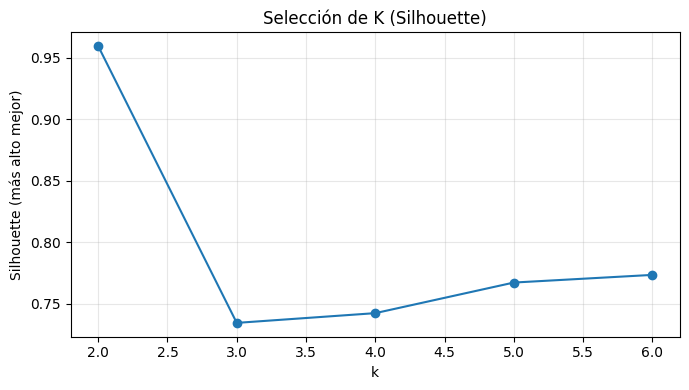

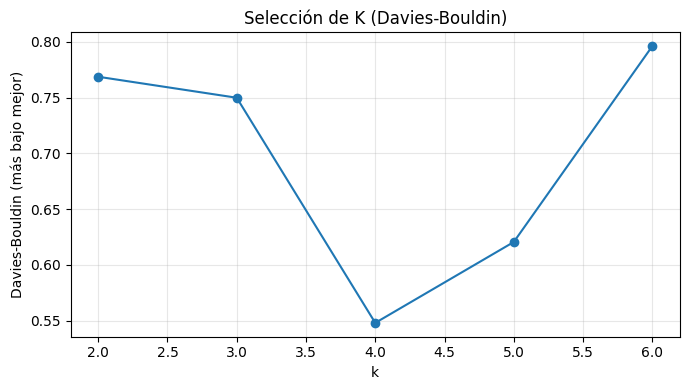

In [86]:
plt.figure(figsize=(7,4))
plt.plot(scores_df["k"], scores_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (más alto mejor)")
plt.title("Selección de K (Silhouette)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin (más bajo mejor)")
plt.title("Selección de K (Davies-Bouldin)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [87]:
K = 3

kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
df_riesgo["cluster_id"] = kmeans.fit_predict(X_scaled)

df_riesgo["cluster_id"].value_counts().sort_index()


cluster_id
0    15511
1    18280
2       28
Name: count, dtype: int64

In [88]:
cluster_stats = (
    df_riesgo.groupby("cluster_id")
    .agg(
        mean_total_delitos=("total_delitos", "mean"),
        mean_ratio_graves=("ratio_graves", "mean"),
        mean_total_graves=("total_graves", "mean"),
        n=("cluster_id", "size")
    )
    .reset_index()
)

cluster_stats = cluster_stats.sort_values(
    ["mean_ratio_graves", "mean_total_delitos"],
    ascending=[True, True]
)

cluster_stats


,cluster_id,mean_total_delitos,mean_ratio_graves,mean_total_graves,n
1,1,2.369639,0.052864,0.180908,18280
2,2,428.285714,0.319141,235.821429,28
0,0,3.491329,0.982736,3.346722,15511


In [89]:
# Orden: menor riesgo -> mayor riesgo
ordered_clusters = cluster_stats["cluster_id"].tolist()

risk_map = {}
if len(ordered_clusters) == 3:
    risk_map[ordered_clusters[0]] = "BAJO"
    risk_map[ordered_clusters[1]] = "MEDIO"
    risk_map[ordered_clusters[2]] = "ALTO"
else:
    # Si usas otro K, asigna por cuantiles o etiqueta "NIVEL_i"
    for i, cid in enumerate(ordered_clusters):
        risk_map[cid] = f"NIVEL_{i+1}"

df_riesgo["nivel_riesgo"] = df_riesgo["cluster_id"].map(risk_map)
df_riesgo[["cluster_id", "nivel_riesgo"]].drop_duplicates().sort_values("cluster_id")


,cluster_id,nivel_riesgo
0,0,ALTO
3,1,BAJO
5303,2,MEDIO


In [90]:
df_clustered = df.merge(
    df_riesgo[group_keys + ["cluster_id", "nivel_riesgo"]],
    on=group_keys,
    how="left"
)

df_clustered[["cluster_id", "nivel_riesgo"]].isna().mean()


cluster_id      0.0
nivel_riesgo    0.0
dtype: float64

In [91]:
perfil_infracciones = (
    df_clustered[df_clustered["es_delito_interes"]]
    .groupby(["cluster_id", "nivel_riesgo", "presunta_infraccion"])
    .size()
    .reset_index(name="conteo")
)

perfil_infracciones["pct"] = (
    perfil_infracciones
    .groupby(["cluster_id"])["conteo"]
    .transform(lambda x: x / x.sum())
)

perfil_infracciones.sort_values(["cluster_id", "pct"], ascending=[True, False]).head(20)


,cluster_id,nivel_riesgo,presunta_infraccion,conteo,pct
0,0,ALTO,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,9378,0.349899
4,0,ALTO,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,8330,0.310798
2,0,ALTO,DELITOS CONTRA LA SEGURIDAD PÚBLICA,4806,0.179315
3,0,ALTO,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,2437,0.090926
1,0,ALTO,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,1851,0.069062
5,1,BAJO,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,1185,0.402240
9,1,BAJO,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,674,0.228785
8,1,BAJO,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,438,0.148676
6,1,BAJO,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,340,0.115411
7,1,BAJO,DELITOS CONTRA LA SEGURIDAD PÚBLICA,309,0.104888


In [92]:
TOP_N = 10

for cid in sorted(df_riesgo["cluster_id"].unique()):
    nivel = df_riesgo.loc[df_riesgo["cluster_id"] == cid, "nivel_riesgo"].iloc[0]
    print(f"\n=== Cluster {cid} | Riesgo: {nivel} ===")
    
    sub = (
        perfil_infracciones[perfil_infracciones["cluster_id"] == cid]
        .sort_values("pct", ascending=False)
        .head(TOP_N)
    )
    if len(sub) == 0:
        print("Sin registros de delitos_interes en este cluster.")
    else:
        display(sub[["presunta_infraccion", "conteo", "pct"]])



=== Cluster 0 | Riesgo: ALTO ===


,presunta_infraccion,conteo,pct
0,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,9378,0.349899
4,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,8330,0.310798
2,DELITOS CONTRA LA SEGURIDAD PÚBLICA,4806,0.179315
3,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,2437,0.090926
1,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,1851,0.069062



=== Cluster 1 | Riesgo: BAJO ===


,presunta_infraccion,conteo,pct
5,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,1185,0.402240
9,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,674,0.228785
8,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,438,0.148676
6,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,340,0.115411
7,DELITOS CONTRA LA SEGURIDAD PÚBLICA,309,0.104888



=== Cluster 2 | Riesgo: MEDIO ===


,presunta_infraccion,conteo,pct
10,DELITOS CONTRA EL DERECHO A LA PROPIEDAD,164,0.386792
14,DELITOS POR LA PRODUCCIÓN O TRÁFICO ILÍCITO DE...,135,0.318396
12,DELITOS CONTRA LA SEGURIDAD PÚBLICA,62,0.146226
11,DELITOS CONTRA LA EFICIENCIA DE LA ADMINISTRAC...,54,0.127358
13,DELITOS DE VIOLENCIA CONTRA LA MUJER O MIEMBRO...,9,0.021226


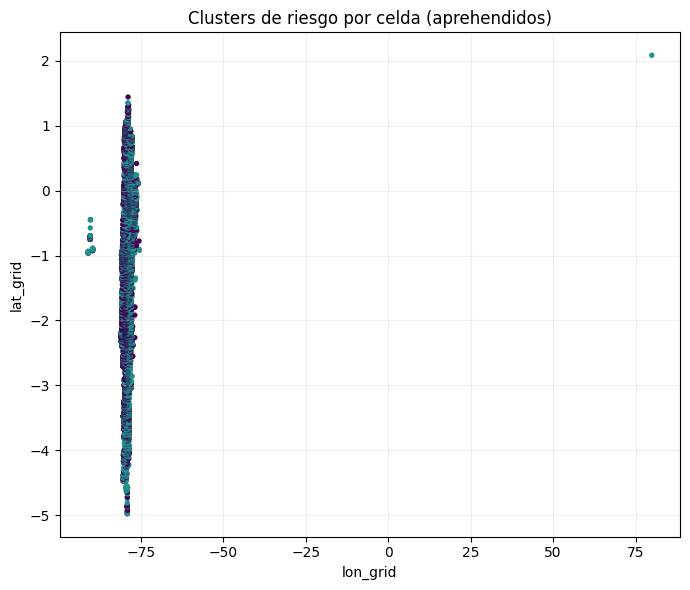

In [93]:
plt.figure(figsize=(7,6))
plt.scatter(df_riesgo["lon_grid"], df_riesgo["lat_grid"], c=df_riesgo["cluster_id"], s=8)
plt.xlabel("lon_grid")
plt.ylabel("lat_grid")
plt.title("Clusters de riesgo por celda (aprehendidos)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


In [94]:
out_cells = OUT_DIR / "riesgo_celdas_aprehendidos.csv"
df_riesgo.to_csv(out_cells, index=False, encoding="utf-8")
print("Guardado:", out_cells)


Guardado: ..\data\processed\aprehendidos_clustering\riesgo_celdas_aprehendidos.csv


In [95]:
out_profile = OUT_DIR / "perfil_infracciones_por_cluster.csv"
perfil_infracciones.to_csv(out_profile, index=False, encoding="utf-8")
print("Guardado:", out_profile)


Guardado: ..\data\processed\aprehendidos_clustering\perfil_infracciones_por_cluster.csv


In [96]:
out_full = OUT_DIR / "aprehendidos_con_cluster_y_riesgo.csv"
df_clustered.to_csv(out_full, index=False, encoding="utf-8")
print("Guardado:", out_full)


Guardado: ..\data\processed\aprehendidos_clustering\aprehendidos_con_cluster_y_riesgo.csv


In [97]:
joblib.dump(kmeans, '../models/trained/modelo_apre_clustering.pkl')

['../models/trained/modelo_apre_clustering.pkl']

# PRUEBAS

# Modelo Riesgo Delictivo

In [98]:
import joblib
import pandas as pd
import os

df = pd.read_csv("../data/processed/dataset_entrenamiento_final_final.csv")
df.head()

target = "conteo_delitos" # columna objetivo
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("RMSE:", rmse)

# GUARDAR EL MODELO
os.makedirs("../models/trained", exist_ok=True)
joblib.dump(model, "../models/trained/modelo_riesgo_delictivo.pkl")




RMSE: 0.3252361604163677


['../models/trained/modelo_riesgo_delictivo.pkl']

# Evaluacion modelo riesgo delictivo

Modelo cargado correctamente.

IMPORTANCIA DE VARIABLES (GAIN)
                  feature  importance
5   conteo_delitos_graves  392.540314
6  conteo_llamadas_riesgo   91.853943
0                lat_grid   20.735426
4              dia_semana   19.668221
3                     dia   19.654032
1                lon_grid   14.296533
2                     mes   11.494623


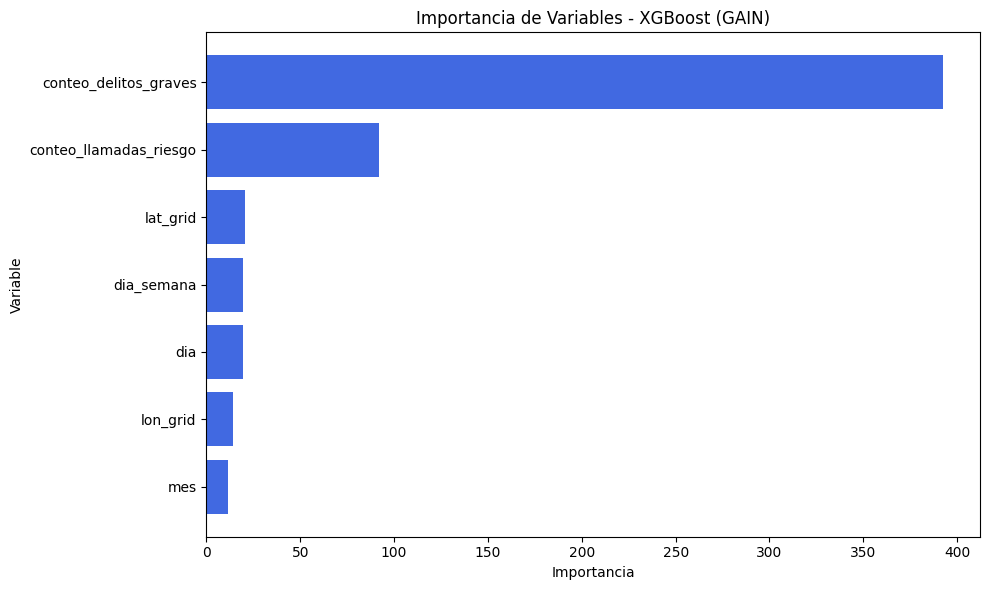

In [99]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. CARGAR EL MODELO ENTRENADO DESDE ARCHIVO
# ============================================================

modelo = joblib.load("../models/trained/modelo_riesgo_delictivo.pkl")

print("Modelo cargado correctamente.")

# ============================================================
# 2. OBTENER IMPORTANCIA DE VARIABLES (XGBoost GAIN)
# ============================================================

booster = modelo.get_booster()
importance = booster.get_score(importance_type='gain')

df_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

df_importance = df_importance.sort_values(by='importance', ascending=False)

print("\n==============================")
print("IMPORTANCIA DE VARIABLES (GAIN)")
print("==============================")
print(df_importance)

# ============================================================
# 3. GRAFICAR IMPORTANCIA DE VARIABLES
# ============================================================

plt.figure(figsize=(10, 6))
plt.barh(df_importance["feature"], df_importance["importance"], color="royalblue")
plt.gca().invert_yaxis()
plt.title("Importancia de Variables - XGBoost (GAIN)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [100]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

In [101]:

# ---------------------------
# Utilidades
# ---------------------------
def _safe_predict_proba(model, X):
    """Devuelve probas de clase positiva si existe predict_proba; si no, intenta decision_function."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        # binario: (n,2) -> columna 1
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        # ya viene como (n,)
        return proba
    raise ValueError("El modelo no tiene predict_proba(). Para clasificación, usa XGBClassifier.")

def _plot_curve(x, y, xlabel, ylabel, title):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

def buscar_threshold_por_recall(model, X_val, y_val, recall_objetivo=0.90):
    """
    Busca un threshold que logre al menos recall_objetivo en val (si es posible),
    priorizando el threshold más alto (menos agresivo) que cumpla el objetivo.
    """
    p = _safe_predict_proba(model, X_val)

    # thresholds candidatos: percentiles -> rápido y suficiente
    candidatos = np.unique(np.quantile(p, np.linspace(0, 1, 200)))
    candidatos = np.clip(candidatos, 0, 1)

    mejor = None
    for thr in sorted(candidatos, reverse=True):
        yhat = (p >= thr).astype(int)
        cm = confusion_matrix(y_val, yhat, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        alert_rate = yhat.mean()
        if recall >= recall_objetivo:
            mejor = (thr, recall, precision, alert_rate, cm)
            break

    if mejor is None:
        # Si no se llega al recall objetivo, devuelve el mejor recall posible (thr bajo)
        best_recall = -1
        best = None
        for thr in sorted(candidatos):
            yhat = (p >= thr).astype(int)
            cm = confusion_matrix(y_val, yhat, labels=[0,1])
            tn, fp, fn, tp = cm.ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            alert_rate = yhat.mean()
            if recall > best_recall:
                best_recall = recall
                best = (thr, recall, precision, alert_rate, cm)
        thr, recall, precision, alert_rate, cm = best
        print(f"No se alcanzó recall objetivo={recall_objetivo:.2f}. Mejor recall={recall:.4f} con thr={thr:.6f}")
        return {"threshold": thr, "recall": recall, "precision": precision, "alert_rate": alert_rate, "confusion": cm}

    thr, recall, precision, alert_rate, cm = mejor
    print(f"Threshold encontrado thr={thr:.6f} | recall={recall:.4f} | precision={precision:.4f} | alert_rate={alert_rate:.4f}")
    return {"threshold": thr, "recall": recall, "precision": precision, "alert_rate": alert_rate, "confusion": cm}


# ---------------------------
# Evaluación: Regresión
# ---------------------------
def evaluar_regresion(
    model,
    X_train, y_train,
    X_val, y_val,
    titulo="Modelo Regresión"
):
    """
    Evaluación:
    - MAE, RMSE, R2 (train/val)
    - Gráfico pred vs real (val)
    - Residuales (val)
    """
    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_val)

    mae_tr = mean_absolute_error(y_train, pred_tr)
    mae_va = mean_absolute_error(y_val, pred_va)

    rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
    rmse_va = np.sqrt(mean_squared_error(y_val, pred_va))

    r2_tr = r2_score(y_train, pred_tr)
    r2_va = r2_score(y_val, pred_va)

    print("="*70)
    print(titulo)
    print("-"*70)
    print(f"MAE   train={mae_tr:.4f} | val={mae_va:.4f}")
    print(f"RMSE  train={rmse_tr:.4f} | val={rmse_va:.4f}")
    print(f"R2    train={r2_tr:.4f} | val={r2_va:.4f}")
    print("="*70)

    # Pred vs Real (val)
    plt.figure()
    plt.scatter(y_val, pred_va, s=10)
    minv = float(min(y_val.min(), pred_va.min()))
    maxv = float(max(y_val.max(), pred_va.max()))
    plt.plot([minv, maxv], [minv, maxv], linestyle="--")
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title("Predicho vs Real (val)")
    plt.grid(True)
    plt.show()

    # Residuales (val)
    resid = y_val - pred_va
    plt.figure()
    plt.scatter(pred_va, resid, s=10)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicho")
    plt.ylabel("Residual (real - predicho)")
    plt.title("Residuales (val)")
    plt.grid(True)
    plt.show()

    return {
        "mae_train": mae_tr, "mae_val": mae_va,
        "rmse_train": rmse_tr, "rmse_val": rmse_va,
        "r2_train": r2_tr, "r2_val": r2_va,
    }

Modelo Regresión
----------------------------------------------------------------------
MAE   train=0.1031 | val=0.1041
RMSE  train=0.3061 | val=0.3100
R2    train=0.9665 | val=0.9657


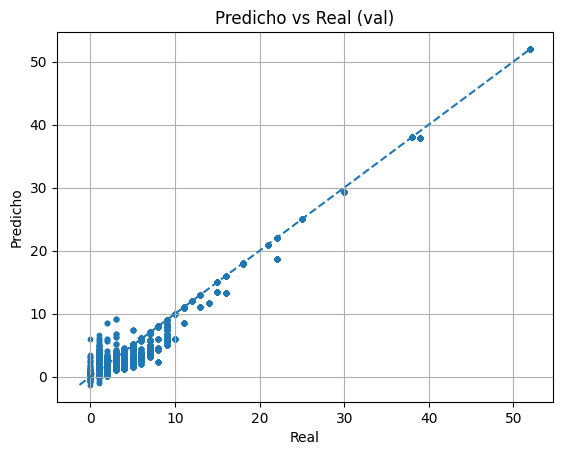

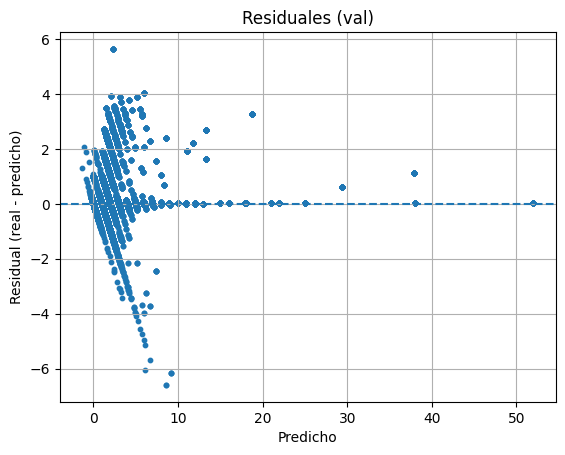

{'mae_train': 0.10306169092655182, 'mae_val': 0.10409972816705704, 'rmse_train': np.float64(0.30606338206236733), 'rmse_val': np.float64(0.30999290190922785), 'r2_train': 0.9664505124092102, 'r2_val': 0.9657158851623535}


In [102]:
metrics_reg = evaluar_regresion(modelo, X_train, y_train, X, y)

print(metrics_reg)

# Modelo clasificacion alto riesgo o no

In [103]:
import joblib
import pandas as pd
import os

df = pd.read_csv("../data/processed/dataset_entrenamiento_final_final.csv")

df["evento_delictivo_grave"] = (df["conteo_delitos_graves"] > 0).astype(int)

df.head()

,lat_grid,lon_grid,mes,dia,dia_semana,conteo_delitos,conteo_delitos_graves,conteo_llamadas_riesgo,evento_delictivo_grave
0,-4.978,-79.116,5,6,1,1,1,0,1
1,-4.977,-79.101,10,15,2,1,1,0,1
2,-4.977,-79.100,10,15,2,1,1,0,1
3,-4.976,-79.115,8,17,6,1,0,0,0
4,-4.959,-79.121,2,1,5,0,0,1,0


In [104]:
df["fecha_dt"] = pd.to_datetime(
    dict(year=2025, month=df["mes"], day=df["dia"]),
    errors="coerce"
)

df = df.dropna(subset=["fecha_dt"])
df = df.sort_values("fecha_dt")

df.head(15)

,lat_grid,lon_grid,mes,dia,dia_semana,conteo_delitos,conteo_delitos_graves,conteo_llamadas_riesgo,evento_delictivo_grave,fecha_dt
198609,1.147,-78.765,1,1,2,0,0,2,0,2025-01-01
77664,-1.753,-78.557,1,1,2,1,1,0,1,2025-01-01
102544,-1.276,-78.585,1,1,2,0,0,5,0,2025-01-01
165896,-0.072,-79.393,1,1,2,0,0,1,0,2025-01-01
84750,-1.637,-78.616,1,1,2,0,0,1,0,2025-01-01
143012,-0.374,-78.370,1,1,2,0,0,5,0,2025-01-01
28941,-2.928,-78.779,1,1,2,0,0,2,0,2025-01-01
41719,-2.477,-79.403,1,1,2,0,0,6,0,2025-01-01
76138,-1.791,-79.532,1,1,2,1,0,0,0,2025-01-01
11626,-3.716,-79.619,1,1,2,0,0,4,0,2025-01-01


In [105]:
from xgboost import XGBClassifier

features = [
  "lat_grid",
  "lon_grid",
  "mes",
  "dia",
  "dia_semana",
  "conteo_llamadas_riesgo"
]

In [106]:
split_date = df["fecha_dt"].quantile(0.8)

train_df = df[df["fecha_dt"] < split_date]
val_df   = df[df["fecha_dt"] >= split_date]

X_train = train_df[features]
y_train = train_df["evento_delictivo_grave"]

X_val = val_df[features]
y_val = val_df["evento_delictivo_grave"]


In [107]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# versiones más conservadoras
scale_pos_weight *= 0.5
# o
# scale_pos_weight = 3
# o
# scale_pos_weight = 5

In [108]:

# model = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     n_estimators=300,
#     max_depth=6,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     scale_pos_weight=scale_pos_weight
# )

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,

    subsample=0.7,
    colsample_bytree=0.7,

    min_child_weight=10,
    gamma=2,

    reg_alpha=1.0,     # L1
    reg_lambda=2.0,    # L2

    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.7
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_metho

In [109]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    f1_score
)

# Probabilidades
y_proba = model.predict_proba(X_val)[:, 1]

# Threshold (ajústalo según política)
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

In [110]:
cm = confusion_matrix(y_val, y_pred)

tn, fp, fn, tp = cm.ravel()

print("Matriz de confusión:")
print(cm)

print(f"""
Verdaderos Positivos (TP): {tp}
Falsos Positivos (FP): {fp}
Verdaderos Negativos (TN): {tn}
Falsos Negativos (FN): {fn}
""")


Matriz de confusión:
[[28872  5310]
 [  111  5997]]

Verdaderos Positivos (TP): 5997
Falsos Positivos (FP): 5310
Verdaderos Negativos (TN): 28872
Falsos Negativos (FN): 111



In [111]:
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

roc_auc = roc_auc_score(y_val, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0     0.9962    0.8447    0.9142     34182
           1     0.5304    0.9818    0.6887      6108

    accuracy                         0.8655     40290
   macro avg     0.7633    0.9132    0.8014     40290
weighted avg     0.9256    0.8655    0.8800     40290

ROC AUC: 0.9440


In [112]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = f1_score(y_val, y_pred)

alert_rate = y_pred.mean()

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Tasa de alertas: {alert_rate:.4f}")


Recall: 0.9818
Precision: 0.5304
F1-score: 0.6887
Tasa de alertas: 0.2806


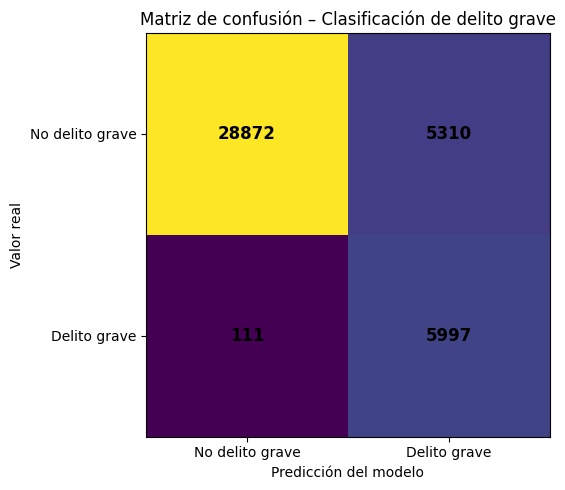

In [113]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["No delito grave", "Delito grave"]

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cm)

# Mostrar valores en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            cm[i, j],
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold"
        )

# Ejes y etiquetas
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("Predicción del modelo")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de confusión – Clasificación de delito grave")

plt.tight_layout()
plt.show()


In [114]:
joblib.dump(model, '../models/trained/modelo_clasificacion_riesgo_delictivo.pkl')

['../models/trained/modelo_clasificacion_riesgo_delictivo.pkl']